### bar_chart

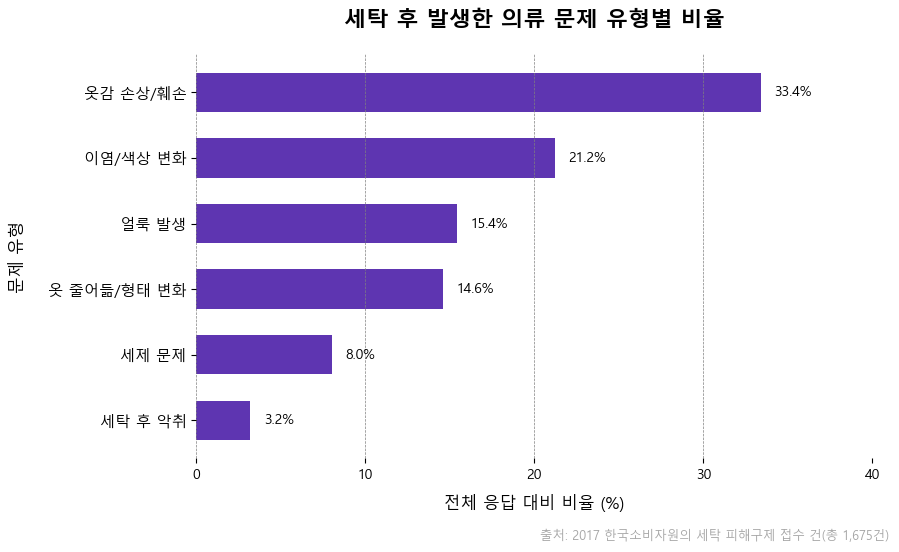

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터
labels = [
    "옷감 손상/훼손",
    "이염/색상 변화",
    "얼룩 발생",
    "옷 줄어듦/형태 변화",
    "세제 문제",
    "세탁 후 악취"
]
values = [33.4, 21.2, 15.4, 14.6, 8.0, 3.2]

# 내림차순 정렬
sorted_data = sorted(zip(values, labels), reverse=True)
values, labels = zip(*sorted_data)
y_pos = np.arange(len(labels))

# 차트 그리기
fig, ax = plt.subplots(figsize=(9, 5.5))  # 크기 약간 줄임

bars = ax.barh(y_pos, values,
               color='#5E35B1',
               height=0.6)

# 퍼센트 표시 (막대 오른쪽)
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.8, bar.get_y() + bar.get_height() / 2,
            f'{width:.1f}%', va='center', ha='left',
            fontsize=10, color='black')

# Y축 설정
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=11)

# X축 설정
ax.set_xlim(0, 40)
ax.set_xticks(np.arange(0, 41, 10))
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=11)

# 타이틀
ax.set_xlabel('전체 응답 대비 비율 (%)', fontsize=12, labelpad=10)
ax.set_ylabel('문제 유형', fontsize=12, labelpad=15)
ax.set_title('세탁 후 발생한 의류 문제 유형별 비율', fontsize=16, weight='bold', pad=20)

# 눈금선, 배경, 테두리 설정
ax.xaxis.grid(True, linestyle='--', linewidth=0.5, color='gray')
ax.yaxis.grid(False)
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# 가장 큰 값이 위로
ax.invert_yaxis()


# 출처 추가
fig.text(0.80, 0.01, '출처: 2017 한국소비자원의 세탁 피해구제 접수 건(총 1,675건)',
         ha='center', fontsize=9, color='gray', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 1])  # 아래쪽 공간 확보

# plt.tight_layout()
plt.show()


### grad_cam

grayscale_cam.max() :::  0.9999999


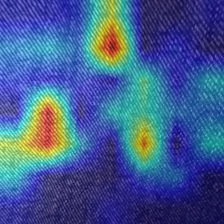

In [4]:
from pytorch_grad_cam import GradCAM, AblationCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.datasets import ImageFolder
from torchvision import transforms
from IPython.display import display
import numpy as np
import torch
import torch.nn as nn
import os
import timm
from PIL import Image

OUT_FEATURES = 10
MODEL_PATH = "model_sav/fabric_classifier_model_multitask_v0.7_143.pth"
# MODEL_PATH = "model_sav/fabric_classifier_model_multitask_v0.6_64.pth"
IMG_PATH = "data/dark_denim.jpg"
# IMG_PATH = "data/silk_background.jpg"
# IMG_PATH = "data/wool_wrinkle.jpg"


###############
# 모델 불러오기
###############
model = timm.create_model("convnextv2_tiny", pretrained=False)
model.head.fc = nn.Linear(model.head.fc.in_features, OUT_FEATURES, bias=True)
model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"), strict=False)
# print(model)

image = Image.open(IMG_PATH)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_img = transform(image).unsqueeze(0)

# 마지막 conv_layer
layer = [model.stages[3].blocks[2].conv_dw]
targets = [ClassifierOutputTarget(1)]

cam = GradCAM(model=model, target_layers=layer)
cam.batch_size = 1
grayscale_cam = cam(input_tensor=input_img, targets=targets)
grayscale_cam = grayscale_cam[0, :]
print("grayscale_cam.max() ::: ", grayscale_cam.max())

# 시각화
image = image.resize((224, 224))
rgb_img = np.float32(image) / 255
result_grad_cam = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
display(Image.fromarray(result_grad_cam))